## Evaluation of Stimuli pre Trial ##

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



*Match stimuli with percieved probability*

In [9]:
def is_red(name):
    return any(substring in name for substring in ["hearts","diamonds"])

def get_responses(stimuli, attention_tests):
    vec_is_red = np.vectorize(is_red)

    stimuli = pd.read_json(stimuli)
    stimuli["stimulus"]= stimuli["stimulus"].apply(lambda x: vec_is_red(np.array(x)).astype(int))
    # stimuli["center_stimulus"] = stimuli["stimulus"].apply(lambda x: np.hsplit(x,np.array([4,9]))[1])
    stimuli["center_prob"] = stimuli["stimulus"].apply(lambda x: x.sum()/x.size *100)

    stimuli_attention = pd.read_json(attention_tests)
    stimuli_attention["stimulus"]= stimuli_attention["stimulus"].apply(lambda x: vec_is_red(np.array(x)).astype(int))
    # stimuli_attention["center_stimulus"] = stimuli_attention["stimulus"].apply(lambda x: np.hsplit(x,np.array([4,9]))[1])
    stimuli_attention["center_prob"] = stimuli_attention["stimulus"].apply(lambda x: x.sum()/x.size *100)

    stimuli = pd.concat([stimuli,stimuli_attention])    

    
    return stimuli

*discretize Percieved Probability*

In [10]:
def discretize_confidence(df_center_responses_level, conf_levels):
    divider = 100/(len(conf_levels)-1)
    df_center_responses_level["dm_conf"] = np.array([conf_levels[int(i)] for i in np.floor(df_center_responses_level["center_prob"]/divider)])
    #set dm_conf to "high" with prob. 0.5 if center_conf is 50
    df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50),"dm_conf"] = np.random.choice(["high", "low"],len(df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50),"dm_conf"]))

    # print("number of 50/50 instances: ", len(df_center_responses_level.loc[(df_center_responses_level["center_prob"]==50)]))
    # print((df_center_responses_level[["center_prob","dm_conf"]]))
    return df_center_responses_level

*Plot expected alignment*

In [11]:
def alignment_plot(df_center_responses_level, conf_levels):
    fig, ax = plt.subplots(figsize=(15, 5))
    df_count = df_center_responses_level.pivot_table(#index='dm_conf', 
                        columns=['dm_conf','AI_conf'], aggfunc='count', fill_value=0, values="center_prob",dropna=False).unstack().reset_index().fillna(value=0).rename(columns={0:'count'})
    # print(df_count)
    ax= sns.barplot(x='AI_conf', y='true_prob', hue='dm_conf', estimator=np.nanmean, errorbar=('ci', 90), errwidth=.2, capsize=.12, hue_order=conf_levels, data=df_center_responses_level)
    for container, conf in zip(ax.containers, conf_levels):
        ax.bar_label(container, labels=df_count[df_count["dm_conf"]==conf]["count"], fmt='%.1f')
    ax.axhline(y=50, color='r', linestyle='dotted')
    plt.show()

*Stripplot of perceived probability per bin - Split by best decision*

In [102]:
def stripplot(df_center_responses_level):
    fig, axes = plt.subplots(4,3, figsize=(13, 10))
    df_center_responses_level["index"] = df_center_responses_level.index

    df_plot_all = df_center_responses_level[["AI_conf","id","center_prob","true_prob","index"]].copy()
    df_plot_all["y_axis"] = df_center_responses_level["center_prob"]
    df_plot_all["x_axis"] = 0.0
    df_plot_all["Best Decision"] = [ ("red" if prob > 50 else "black") for prob in df_plot_all["true_prob"]]


    for i, ai_conf in enumerate([8,15,23,31,38,46,54,62,69,77,85,92]):

        ax=axes[i//3][i%3]
        print(i//3, i%3)
        df_plot = df_plot_all.loc[ df_plot_all["AI_conf"]==ai_conf].copy()
        
        #
        ax.axhline(y=50, color='r', linestyle='dotted')
        ax.set(xlim=(-0.3,0.3), ylim=(0,100))
        
        sns.stripplot(x="x_axis", y="y_axis", hue="Best Decision", dodge=0.4, alpha=.2, hue_order=["black", "red"], data=df_plot, ax=ax, legend=False)
        
        if (df_plot["Best Decision"]=="red").sum() == 0:
            # df_plot["x_axis"] = -0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', data=df_plot, errorbar=('ci', 95), ax=ax)
        elif (df_plot["Best Decision"]=="black").sum() == 0:
            # df_plot["x_axis"] = 0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', color="darkorange", data=df_plot, errorbar=('ci', 95), ax=ax)
        else:
            sns.pointplot(x="x_axis", y="y_axis", hue="Best Decision",  markers=['s','s'], hue_order=["black", "red"], data=df_plot, errorbar=('ci', 95), ax=ax)
            #dodge=0.4,

        ax.plot(0., df_plot.loc[df_plot["Best Decision"]=="red", "true_prob"].mean(),color="red", marker='x', markersize=10)
        ax.plot(0., df_plot.loc[df_plot["Best Decision"]=="black", "true_prob"].mean(),color="black", marker='x', markersize=10)
        
        ax.set_title(f"AI confidence: {ai_conf}")
        ax.set_ylabel("Stated confidence")
        ax.set_xlabel("")
        ax.set_xticklabels(["Center Probability"])

    fig.tight_layout()
    plt.show()

*Stripplot of decisions per bin - Split by best decision*

In [13]:
def stripplot_decision(df_center_responses_level):

    fig, axes = plt.subplots(2,3, figsize=(13, 10))
    df_center_responses_level["index"] = df_center_responses_level.index

    df_plot_all = df_center_responses_level[["AI_conf","id","dm_conf","center_prob","true_prob","index"]].copy()
    df_plot_all["y_axis"] = df_center_responses_level["dm_conf"].apply(lambda x: int(x in ["high", "very high"]))
    df_plot_all["x_axis"] = 0.0
    df_plot_all["Best Decision"] = [ ("red" if prob > 50 else "black") for prob in df_plot_all["true_prob"]]


    for i, ai_conf in enumerate([31,38,46,54,62,69]):

        ax=axes[i//3][i%3]
        df_plot = df_plot_all.loc[ df_plot_all["AI_conf"]==ai_conf].copy()
        
        ax.axhline(y=0.5, color='r', linestyle='dotted')
        sns.stripplot(x="x_axis", y="y_axis", hue="Best Decision", dodge=0.4, alpha=.2, hue_order=["black", "red"], data=df_plot, ax=ax, legend=False)

        if (df_plot["Best Decision"]=="red").sum() == 0:
            # df_plot.loc[:, "x_axis"] = -0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', data=df_plot, errorbar=('ci', 95), ax=ax)
        elif (df_plot["Best Decision"]=="black").sum() == 0:
            # df_plot.loc[:, "x_axis"] = 0.3
            sns.pointplot(x="x_axis", y="y_axis", markers='s', color="darkorange", data=df_plot, errorbar=('ci', 95), ax=ax)
        else:
            sns.pointplot(x="x_axis", y="y_axis", hue="Best Decision", markers=['s','s'], hue_order=["black", "red"], data=df_plot, errorbar=('ci', 95), ax=ax)
            #dodge=0.4,

        ax.set_title(f"AI confidence: {ai_conf}")
        ax.set_ylabel("Decision")
        ax.set_xlabel("")
        ax.set_xticklabels(["Center Probability"])

    fig.tight_layout()
    plt.show()

*Show stimulus*

In [33]:
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import ImageGrid

def show_grid(images):
    # Determine the layout of the grid
    grid_size = (4, 5)  # Change this to fit your needs

    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=(7, 5))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

    for i, img_file in enumerate(images):
        # Read the image file
        img = mpimg.imread(img_file)

        # Plot the image in the grid
        axs[i // grid_size[1], i % grid_size[1]].imshow(img)
        axs[i // grid_size[1], i % grid_size[1]].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

### Create Stimuli ###

In [84]:
import create_stimuli_per_bin_center
import importlib
importlib.reload(create_stimuli_per_bin_center)

stimuli_hard, stimuli_random, stimuli_easy, attention = create_stimuli_per_bin_center.create_all_stimuli()

df_hard = pd.read_json(stimuli_hard)
df_random = pd.read_json(stimuli_random)
df_easy = pd.read_json(stimuli_easy)
print("Number of stimuli per level: ", df_hard.shape[0], df_random.shape[0], df_easy.shape[0])

{0: 0, 1: 15, 2: 30, 3: 45, 4: 270, 5: 270, 6: 270, 7: 270, 8: 270, 9: 270, 10: 45, 11: 30, 12: 15, 13: 0}
0 0
1 7
2 14
6 18
8 24
10 30
14 34
18 38
22 42
28 44
34 46
38 50
45 51
52 52
Number of stimuli per level:  1800 1800 1800


### Show specific stimulus ###

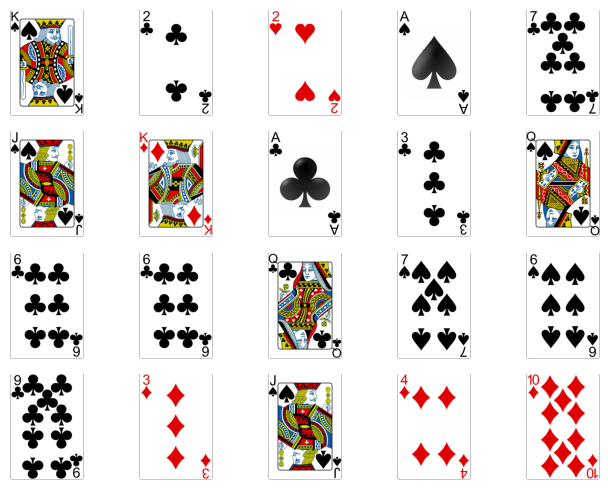

In [85]:
hard_stimuli_trial_I = pd.read_json(open(f"./extra/experiment_trial_I/materials/stimuli_hard.json"))
# hard_stimuli_trial_I = pd.read_json(open(f"./extra/materials_trial_seed4203/stimuli_hard.json"))

show_grid(np.array(hard_stimuli_trial_I.loc[60,"stimulus"])[:,4:9].flatten().tolist())

id                                                         60
batch                                                    game
stimulus    [[img/king_of_diamonds2.png, img/6_of_diamonds...
cards       [img/6_of_diamonds.png, img/king_of_diamonds2....
nr_reds                                                     7
nr_total                                                   52
AI_reds                                                     3
AI_total                                                   13
AI_conf                                                    23
Name: 60, dtype: object


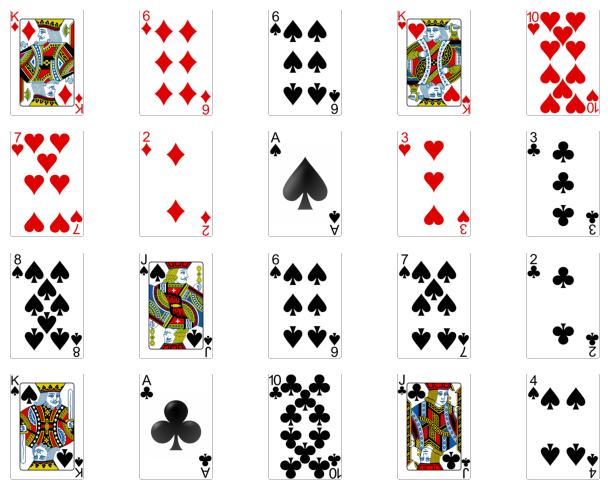

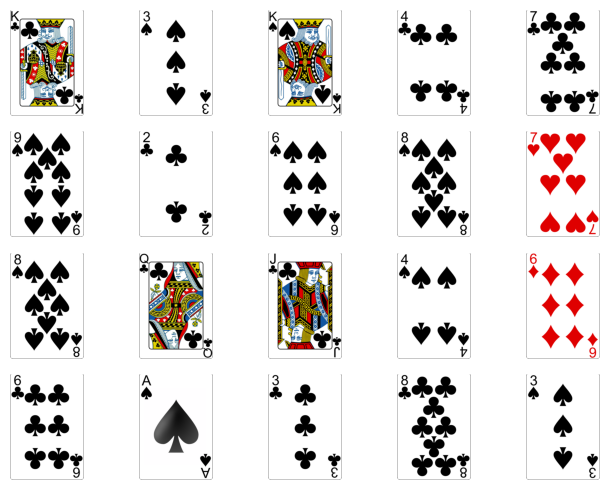

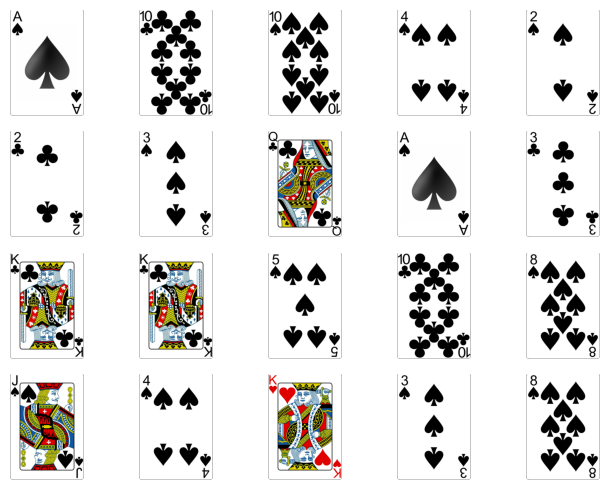

In [86]:
print(df_hard.loc[60])
show_grid(np.array(df_hard.loc[60,"stimulus"]).flatten().tolist())
show_grid(np.array(df_random.loc[60,"stimulus"]).flatten().tolist())
show_grid(np.array(df_easy.loc[60,"stimulus"]).flatten().tolist())

### Plot distribution of instances ###

0     0.008333
1     0.016667
2     0.025000
3     0.150000
4     0.150000
5     0.150000
6     0.150000
7     0.150000
8     0.150000
9     0.025000
10    0.016667
11    0.008333
Name: true_prob, dtype: float64


<Axes: xlabel='true_prob', ylabel='AI_conf'>

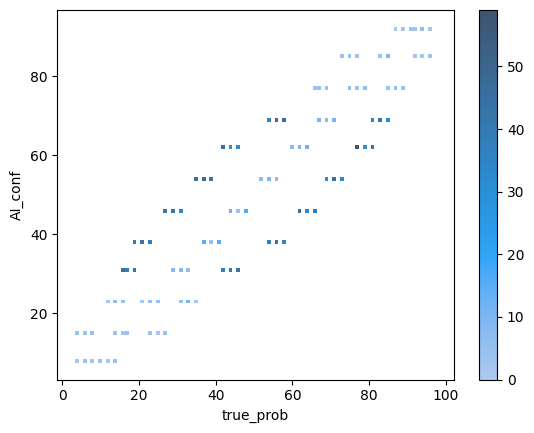

In [87]:
df_hard["true_prob"] = df_hard["nr_reds"]/df_hard["nr_total"]*100

df = df_hard[["true_prob","AI_conf"]].copy()
"Probability per AI confidence (bin): "
print(df.groupby(["AI_conf"], as_index=False).count()["true_prob"]/df.shape[0])
sns.histplot(df, x="true_prob", y="AI_conf", discrete=(True, True),  cbar='true' )

### Calibration Metrics of AI ###

In [89]:
ece = df.groupby(by=['AI_conf'], as_index=False).mean()
print(ece)
print( "ECE:", abs(ece['AI_conf']-ece['true_prob']).mean()/100)
print( "MCE:", abs(ece['AI_conf']-ece['true_prob']).max()/100)

    AI_conf  true_prob
0         8   9.102564
1        15  14.551282
2        23  24.102564
3        31  30.484330
4        38  38.112536
5        46  46.011396
6        54  52.421652
7        62  62.955840
8        69  68.198006
9        77  77.136752
10       85  82.948718
11       92  92.564103
ECE: 0.007818138651471976
MCE: 0.02051282051282044


### Get Perceived Probabilities ###

In [90]:
df_center_responses_hard = get_responses(stimuli_hard, attention)  
df_center_responses_hard["true_prob"] = df_center_responses_hard["nr_reds"]/df_center_responses_hard["nr_total"]*100

df_center_responses_random = get_responses(stimuli_random, attention)  
df_center_responses_random["true_prob"] = df_center_responses_random["nr_reds"]/df_center_responses_random["nr_total"]*100

df_center_responses_easy = get_responses(stimuli_easy, attention)  
df_center_responses_easy["true_prob"] = df_center_responses_easy["nr_reds"]/df_center_responses_easy["nr_total"]*100

### Expected Utility ###

In [91]:
def estimated_utility(stimuli):
    df_utility = stimuli[["AI_conf","center_prob","true_prob"]].copy()

    df_utility["Decision Best"] = df_utility["true_prob"]>50
    df_utility["Decision AI"] = df_utility["AI_conf"]>50
    df_utility["Decision Human"] = df_utility["center_prob"]>50

    df_utility["Utility AI"] = df_utility["Decision AI"]*df_utility["true_prob"] + (1-df_utility["Decision AI"])*(100-df_utility["true_prob"])
    df_utility["Utility Human"] = df_utility["Decision Human"]*df_utility["true_prob"] + (1-df_utility["Decision Human"])*(100-df_utility["true_prob"])
    df_utility["Utility Best"] = df_utility["Decision Best"]*df_utility["true_prob"] + (1-df_utility["Decision Best"])*(100-df_utility["true_prob"])

    # df_utility
    print("Utility Best: ", df_utility["Utility Best"].mean())
    print("Utility AI: ", df_utility["Utility AI"].mean())
    print("Utility Human: ", df_utility["Utility Human"].mean())

    exp_points = ((df_utility["Utility Human"].mean()/100 + max(df_utility["Utility AI"].mean(), df_utility["Utility Human"].mean())/100) - (1- df_utility["Utility AI"].mean()/100))* 20
    print("Expected Points in Game: ", exp_points )
    print("Expected Reward in Game: ", exp_points*0.04 )
    print()


In [92]:
print("Level Hard")
estimated_utility(df_center_responses_hard)

print("Level Random")
estimated_utility(df_center_responses_random)

print("Level Easy")
estimated_utility(df_center_responses_easy)

Level Hard
Utility Best:  68.74786798567287
Utility AI:  63.54575302746034
Utility Human:  50.08634658024902
Expected Points in Game:  15.435570527033942
Expected Reward in Game:  0.6174228210813577

Level Random
Utility Best:  68.74786798567287
Utility AI:  63.54575302746034
Utility Human:  67.47931946102678
Expected Points in Game:  19.70087838990278
Expected Reward in Game:  0.7880351355961112

Level Easy
Utility Best:  68.74786798567287
Utility AI:  63.54575302746034
Utility Human:  65.80355619989766
Expected Points in Game:  19.03057308545113
Expected Reward in Game:  0.7612229234180452



### Alignemnt and Stripplots for Hard Level ###

/Users/ninacobe/Library/Python/3.8/lib/python/site-packages/seaborn/_statistics.py:486: RuntimeWarning: Mean of empty slice
  estimate = self.estimator(vals)


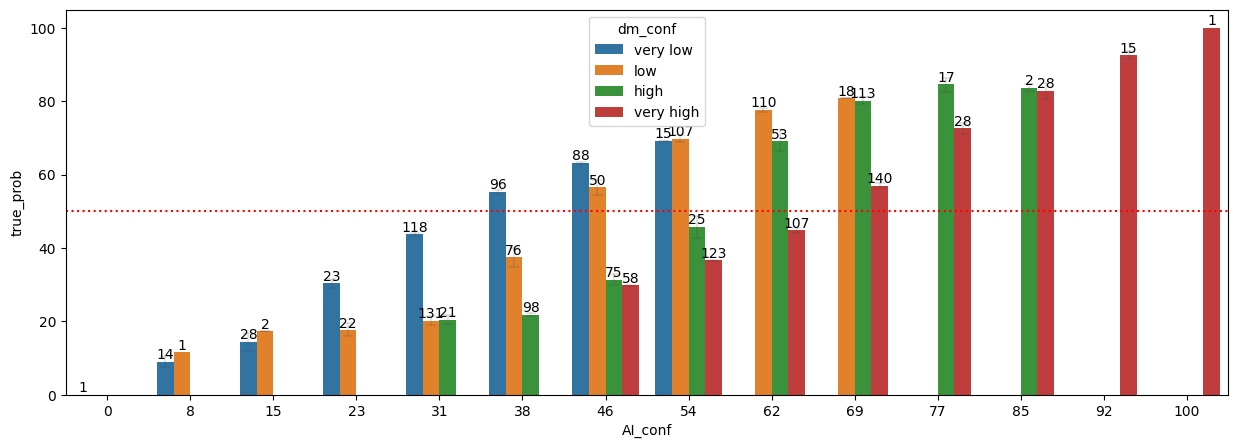

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
3 0
3 1
3 2


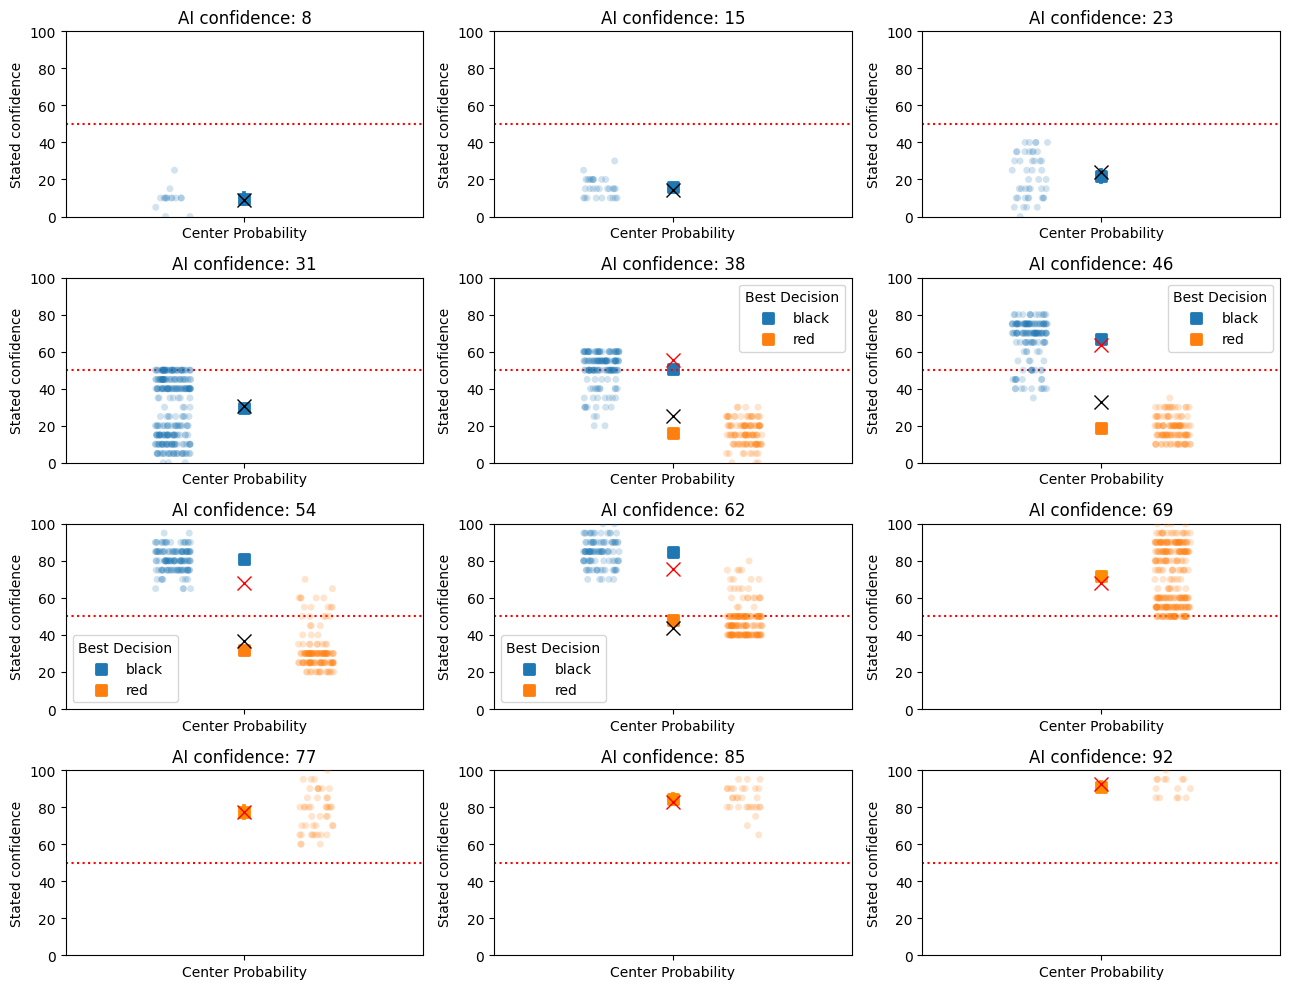

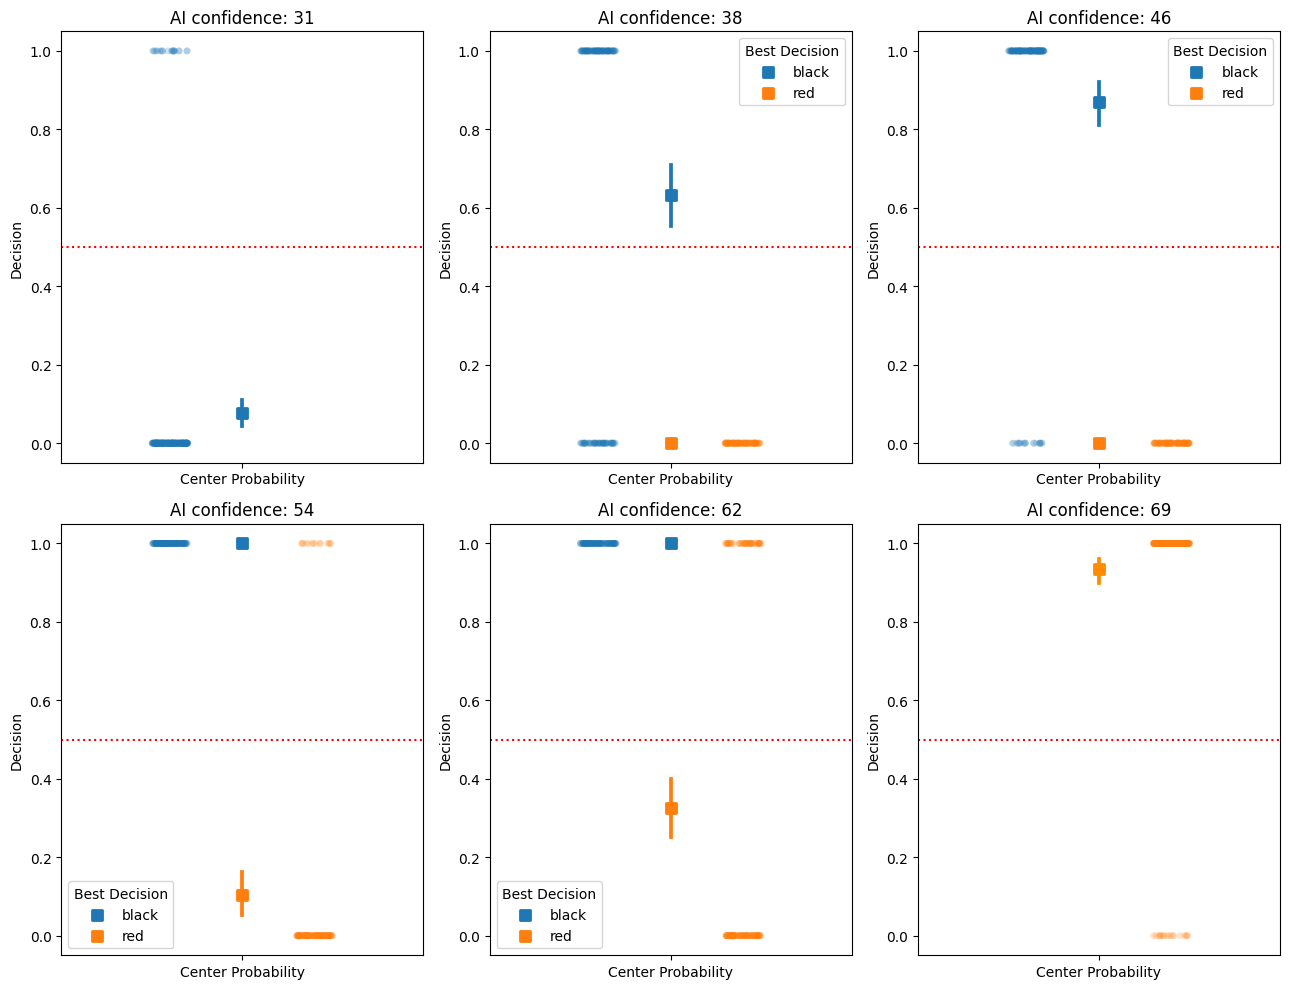

In [103]:
conf_levels = ["very low", "low", "high", "very high","very high"]

df_center_responses_hard = discretize_confidence(df_center_responses_hard, conf_levels)
alignment_plot(df_center_responses_hard, conf_levels[0:4])
stripplot(df_center_responses_hard)
stripplot_decision(df_center_responses_hard)

In [19]:
df_center_responses_hard

,id,batch,stimulus,cards,nr_reds,nr_total,AI_reds,AI_total,AI_conf,center_prob,true_prob,dm_conf,index
0,0,game,"[[0, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 1, 0, 0...","[img/5_of_diamonds.png, img/king_of_hearts2.pn...",5,52,1,13,8,10.0,9.615385,very low,0
1,1,game,"[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0...","[img/ace_of_diamonds.png, img/jack_of_hearts2....",3,52,1,13,8,0.0,5.769231,very low,1
2,2,game,"[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0...","[img/8_of_diamonds.png, img/5_of_hearts.png, i...",5,52,1,13,8,5.0,9.615385,very low,2
3,3,game,"[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0...","[img/5_of_diamonds.png, img/4_of_hearts.png, i...",3,52,1,13,8,0.0,5.769231,very low,3
4,4,game,"[[0, 0, 1, 0, 0], [0, 0, 1, 0, 1], [0, 0, 0, 0...","[img/6_of_diamonds.png, img/jack_of_hearts2.pn...",7,52,1,13,8,15.0,13.461538,very low,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1799,1799,game,"[[0, 1, 1, 1, 1], [0, 1, 1, 1, 1], [1, 1, 1, 0...","[img/7_of_hearts.png, img/ace_of_diamonds.png,...",49,52,12,13,92,85.0,94.230769,very high,1799
0,-1,attention,"[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...","[img/5_of_hearts.png, img/jack_of_diamonds2.pn...",52,52,13,13,100,100.0,100.000000,very high,0
1,-2,attention,"[[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0...","[img/4_of_clubs.png, img/10_of_clubs.png, img/...",0,52,0,13,0,0.0,0.000000,very low,1
2,-3,attention,"[[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1...","[img/4_of_hearts.png, img/ace_of_hearts.png, i...",39,52,9,13,69,75.0,75.000000,very high,2
